# Vacancy Rate of Seattle Airbnb

Analysis done in this notebook is to answer the following questions:
1. Which neighborhoods are popular according to Airbnb vacancy rate?
2. Would vacancy rate vary among different property types?
3. Would cancellation policy affect vacancy rate?
4. Would minimum nights policy affect vacancy rate?

# 1. A Quick look at the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_listings = pd.read_csv('listings.csv')


In [2]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [3]:
df_listings['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

**Here, we want to ignore the rare property types and only look at the ones that has a total number of at least 20.**

In [4]:
property_selector = ((df_listings['property_type'] == "House") 
                     | (df_listings['property_type'] == "Apartment")
                     | (df_listings['property_type'] == "Townhouse")
                     | (df_listings['property_type'] == "Condominium")
                     | (df_listings['property_type'] == "Loft")
                     | (df_listings['property_type'] == "Bed & Breakfast")
                     | (df_listings['property_type'] == "Cabin")
                    )
df_selected = df_listings[property_selector]
df_selected.head()


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


**Select the columns that are most relavent to the problems that we want to solve**

In [5]:
#select the columns that are most relavent to the problems that we want to solve
df_selected = df_selected[['id', 'neighbourhood', 'accommodates', 'zipcode', 'room_type', 'property_type','cancellation_policy','minimum_nights']]
df_selected.rename(columns = {'id': 'listing_id'}, inplace = True)
df_selected.head()

,listing_id,neighbourhood,accommodates,zipcode,room_type,property_type,cancellation_policy,minimum_nights
0,241032,Queen Anne,4,98119,Entire home/apt,Apartment,moderate,1
1,953595,Queen Anne,4,98119,Entire home/apt,Apartment,strict,2
2,3308979,Queen Anne,11,98119,Entire home/apt,House,strict,4
3,7421966,Queen Anne,3,98119,Entire home/apt,Apartment,flexible,1
4,278830,Queen Anne,6,98119,Entire home/apt,House,strict,1


In [6]:
df_calendar = pd.read_csv('calendar.csv')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
df_listings.shape

(3818, 92)

In [8]:
df_calendar.shape

(1393570, 4)

In [9]:
3818*365

1393570

#  2. Data Analysis

## 2.1 Calculating vacancy rate for each listing from calendar.csv

In [10]:
df_vacancy_t = df_calendar[df_calendar['available'] == 't'].groupby('listing_id').count()['available'].reset_index()
df_vacancy_t.rename(columns = {'available': 'available_true'}, inplace = True)
df_vacancy_f = df_calendar[df_calendar['available'] == 'f'].groupby('listing_id').count()['available'].reset_index()
df_vacancy_f.rename(columns = {'available': 'available_false'}, inplace = True)
df_vacancy = pd.merge(df_vacancy_t, df_vacancy_f, how='outer', on='listing_id')
df_vacancy.fillna(0, inplace=True)
df_vacancy['vacancy_rate'] = df_vacancy['available_true'] / (df_vacancy['available_true'] + df_vacancy['available_false'])
df_vacancy

,listing_id,available_true,available_false,vacancy_rate
0,3335,309.0,56.0,0.846575
1,4291,365.0,0.0,1.000000
2,5682,309.0,56.0,0.846575
3,6606,365.0,0.0,1.000000
4,7369,53.0,312.0,0.145205
5,9419,365.0,0.0,1.000000
6,9460,57.0,308.0,0.156164
7,9531,180.0,185.0,0.493151
8,9534,262.0,103.0,0.717808
9,9596,363.0,2.0,0.994521


**Merge the two tables and correct an input typo.**

In [11]:
df_joined = pd.merge(df_selected, df_vacancy, how='left', on='listing_id' )
df_joined

,listing_id,neighbourhood,accommodates,zipcode,room_type,property_type,cancellation_policy,minimum_nights,available_true,available_false,vacancy_rate
0,241032,Queen Anne,4,98119,Entire home/apt,Apartment,moderate,1,346.0,19.0,0.947945
1,953595,Queen Anne,4,98119,Entire home/apt,Apartment,strict,2,291.0,74.0,0.797260
2,3308979,Queen Anne,11,98119,Entire home/apt,House,strict,4,220.0,145.0,0.602740
3,7421966,Queen Anne,3,98119,Entire home/apt,Apartment,flexible,1,143.0,222.0,0.391781
4,278830,Queen Anne,6,98119,Entire home/apt,House,strict,1,365.0,0.0,1.000000
5,5956968,Queen Anne,2,98119,Private room,House,strict,1,302.0,63.0,0.827397
6,1909058,Queen Anne,2,98119,Private room,House,moderate,3,346.0,19.0,0.947945
7,856550,Queen Anne,2,98119,Private room,Cabin,strict,2,100.0,265.0,0.273973
8,4948745,Queen Anne,2,98109,Private room,Apartment,strict,3,341.0,24.0,0.934247
9,2493658,Queen Anne,4,98119,Entire home/apt,Apartment,strict,2,324.0,41.0,0.887671


In [12]:
df_joined[df_joined['zipcode'] == '99\n98122']


,listing_id,neighbourhood,accommodates,zipcode,room_type,property_type,cancellation_policy,minimum_nights,available_true,available_false,vacancy_rate
844,9448215,NaN,2,99\n98122,Private room,House,flexible,1,365.0,0.0,1.0


In [13]:
df_joined.replace('99\n98122', '98122', inplace = True)
df_joined[df_joined['zipcode'] == '99\n98122']

,listing_id,neighbourhood,accommodates,zipcode,room_type,property_type,cancellation_policy,minimum_nights,available_true,available_false,vacancy_rate


## 2.2 Vacancy rate by neighborhood

In [14]:
df_vacancy_nbh = df_joined[['neighbourhood', 'vacancy_rate']]
df_vacancy_nbh = df_vacancy_nbh.groupby('neighbourhood').agg(['median', 'mean', 'count'])
df_vacancy_nbh.columns = df_vacancy_nbh.columns.droplevel()
df_vacancy_nbh.reset_index(inplace = True)

df_vacancy_nbh.sort_values(by='median', inplace = True)

#neighborhoods with less than 2 rentals don't provide statistical values, so filter them out
df_vacancy_nbh = df_vacancy_nbh[df_vacancy_nbh['count'] > 2]
df_vacancy_nbh

,neighbourhood,median,mean,count
8,Broadway,0.172603,0.480000,5
48,North Beach/Blue Ridge,0.249315,0.436438,10
69,South Lake Union,0.394521,0.443183,21
62,Riverview,0.501370,0.538014,8
77,Wedgewood,0.504110,0.579726,15
15,Dunlap,0.512329,0.612453,11
37,Lower Queen Anne,0.513699,0.559840,82
22,Genesee,0.624658,0.573264,29
4,Belltown,0.627397,0.616344,204
75,View Ridge,0.650685,0.615525,6


In [15]:
df_vacancy_nbh['median'].median()

0.8486301369863014

In [16]:
df_vacancy_nbh_top = df_vacancy_nbh.head(5)
df_vacancy_nbh_top

,neighbourhood,median,mean,count
8,Broadway,0.172603,0.480000,5
48,North Beach/Blue Ridge,0.249315,0.436438,10
69,South Lake Union,0.394521,0.443183,21
62,Riverview,0.501370,0.538014,8
77,Wedgewood,0.504110,0.579726,15


In [17]:
df_vacancy_nbh_tail = df_vacancy_nbh.tail(5)
df_vacancy_nbh_tail

,neighbourhood,median,mean,count
28,High Point,0.980822,0.903861,11
80,Yesler Terrace,0.989041,0.871005,12
30,Holly Park,0.991781,0.972146,6
6,Brighton,0.991781,0.738082,5
52,Olympic Hills,0.993151,0.739726,12


In [18]:
df_nbh_count = df_vacancy_nbh.sort_values(by='count', ascending = False)
df_nbh_count

,neighbourhood,median,mean,count
10,Capitol Hill,0.775342,0.617890,351
3,Ballard,0.841096,0.692966,208
4,Belltown,0.627397,0.616344,204
44,Minor,0.906849,0.702632,191
59,Queen Anne,0.775342,0.637115,181
20,Fremont,0.853425,0.669450,146
76,Wallingford,0.890411,0.690104,143
73,University District,0.946575,0.736599,106
19,First Hill,0.712329,0.594494,105
71,Stevens,0.904110,0.704281,96


## 2.3 Vacancy rate by property type

In [19]:
df_vacancy_type = df_joined[['property_type', 'room_type', 'vacancy_rate']]
df_vacancy_type = df_vacancy_type.groupby(['property_type', 'room_type']).agg(['median', 'mean', 'count'])
df_vacancy_type.columns = df_vacancy_type.columns.droplevel()
df_vacancy_type.reset_index(inplace = True)
df_vacancy_type.sort_values(by='median', inplace = True)
df_vacancy_type

,property_type,room_type,median,mean,count
8,Condominium,Entire home/apt,0.490411,0.542504,72
17,Townhouse,Entire home/apt,0.505479,0.555454,54
3,Bed & Breakfast,Entire home/apt,0.594521,0.674886,3
19,Townhouse,Shared room,0.615068,0.615068,2
7,Cabin,Private room,0.657534,0.621370,5
11,House,Entire home/apt,0.749315,0.634161,894
14,Loft,Entire home/apt,0.763014,0.626484,30
0,Apartment,Entire home/apt,0.789041,0.647024,1428
9,Condominium,Private room,0.801370,0.709285,18
10,Condominium,Shared room,0.846575,0.846575,1


## 2.4 Vacancy rate by cancellation policy


In [20]:
df_vacancy_cancel = df_joined[['cancellation_policy', 'vacancy_rate']]
df_vacancy_cancel = df_vacancy_cancel.groupby('cancellation_policy').agg(['median', 'mean', 'count'])
df_vacancy_cancel.columns = df_vacancy_cancel.columns.droplevel()
df_vacancy_cancel.reset_index(inplace = True)
df_vacancy_cancel.sort_values(by='median', inplace = True)
df_vacancy_cancel

,cancellation_policy,median,mean,count
1,moderate,0.810959,0.655476,1231
0,flexible,0.845205,0.653765,1120
2,strict,0.865753,0.693631,1397


## 2.5 Vacancy rate by minimal days

In [21]:
df_vacancy_minimum = df_joined[['minimum_nights', 'vacancy_rate']]
df_vacancy_minimum = df_vacancy_minimum.groupby('minimum_nights').agg(['median', 'mean', 'count'])
df_vacancy_minimum.columns = df_vacancy_minimum.columns.droplevel()
df_vacancy_minimum.reset_index(inplace = True)
df_vacancy_minimum.sort_values(by='median', inplace = True)
df_vacancy_minimum


,minimum_nights,median,mean,count
10,12,0.000000,0.000000,1
13,15,0.035616,0.035616,1
9,11,0.142466,0.142466,1
17,28,0.331507,0.331507,1
15,21,0.358904,0.358904,1
16,26,0.419178,0.419178,1
5,6,0.427397,0.465925,16
12,14,0.500000,0.636644,16
7,8,0.526027,0.526027,1
4,5,0.589041,0.614108,67


**There are a few rentals that have minimum_nights greater than 14 days, but the count for each is too low to be valuable, so filter them out.**

In [22]:
df_vacancy_minimum = df_vacancy_minimum[df_vacancy_minimum['minimum_nights'] <= 14]
df_vacancy_minimum

,minimum_nights,median,mean,count
10,12,0.000000,0.000000,1
9,11,0.142466,0.142466,1
5,6,0.427397,0.465925,16
12,14,0.500000,0.636644,16
7,8,0.526027,0.526027,1
4,5,0.589041,0.614108,67
11,13,0.608219,0.608219,2
8,10,0.638356,0.555616,5
6,7,0.717808,0.615945,50
2,3,0.802740,0.655736,477


# 3. Visualization of the above results

## 3.1 Add tables for vacancy rate by neighborhood 

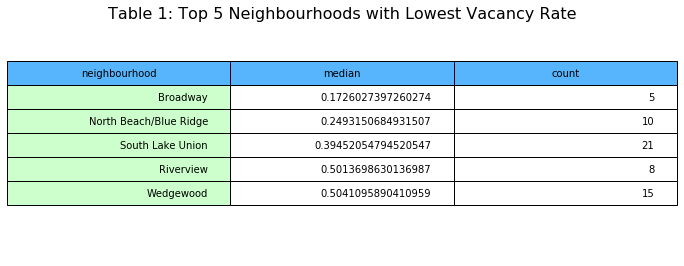

In [23]:
fig, ax = plt.subplots()

# hide axes
ax.axis('off')
ax.axis('auto')

df_vacancy_rate_top5 = df_vacancy_nbh[['neighbourhood', 'median', 'count']].head(5)
table_top5 = ax.table(cellText = df_vacancy_rate_top5.values, colLabels = df_vacancy_rate_top5.columns, loc = 'center')
table_top5.scale(2, 2)

# set colors of first row and first column
for i in range(0, 3):
    table_top5._cells[(0, i)].set_facecolor("#56b5fd")

for i in range(1, 6):
    table_top5._cells[(i, 0)].set_facecolor("#CCFFCC")

ax.set_title("Table 1: Top 5 Neighbourhoods with Lowest Vacancy Rate", fontsize = 16)
plt.show()

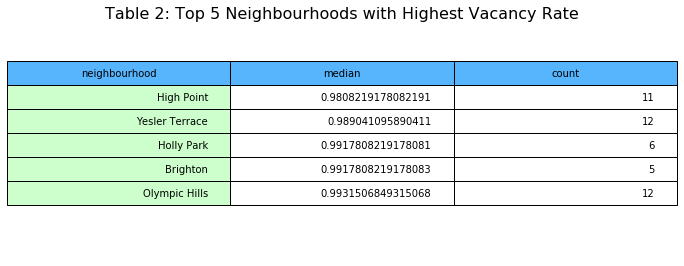

In [24]:
fig, ax = plt.subplots()

# hide axes
ax.axis('off')
ax.axis('tight')

df_vacancy_rate_bot5 = df_vacancy_nbh[['neighbourhood', 'median', 'count']].tail(5)
table_bot5 = ax.table(cellText = df_vacancy_rate_bot5.values, colLabels = df_vacancy_rate_bot5.columns, loc = 'center')
table_bot5.scale(2, 2)

# set colors of first row and first column
for i in range(0, 3):
    table_bot5._cells[(0, i)].set_facecolor("#56b5fd")

for i in range(1, 6):
    table_bot5._cells[(i, 0)].set_facecolor("#CCFFCC")

ax.set_title("Table 2: Top 5 Neighbourhoods with Highest Vacancy Rate", fontsize = 16)
plt.show()

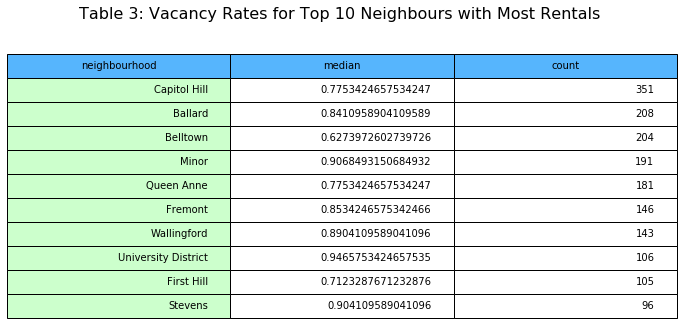

In [25]:
fig, ax = plt.subplots()

# hide axes
ax.axis('off')
ax.axis('tight')

df_vacancy_count_top10 = df_nbh_count[['neighbourhood', 'median', 'count']].head(10)
table_count10 = ax.table(cellText = df_vacancy_count_top10.values, colLabels = df_vacancy_count_top10.columns, loc = 'center')
#fig.set_size_inches(6, 8)
table_count10.scale(2, 2)

# set colors of first row and first column
for i in range(0, 3):
    table_count10._cells[(0, i)].set_facecolor("#56b5fd")

for i in range(1, 11):
    table_count10._cells[(i, 0)].set_facecolor("#CCFFCC")

#add extra '\n's at the end of the title to work around the problem of titile overlapping with the table
ax.set_title("Table 3: Vacancy Rates for Top 10 Neighbours with Most Rentals \n\n\n", fontsize = 16)
plt.show()

Text(0,0.5,'Vacancy Rate')

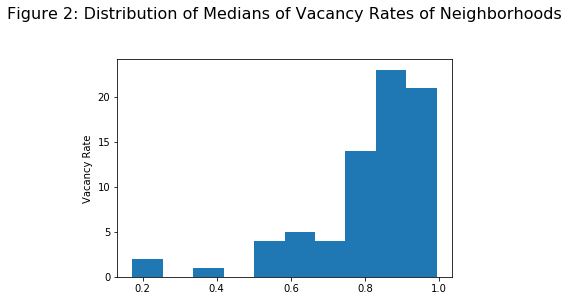

In [32]:
# This plot is to help me understand the data. It may confuse non-technical audience so won't be included on the blog 
plt.hist(df_vacancy_nbh['median'])
plt.title('Distribution of Median Vacancy Rates of Neighborhoods\n\n', fontsize = 16)
plt.ylabel('Number of Neighborhoods')
plt.ylabel('Vacancy Rate')

Text(0,0.5,'Vacancy Rate')

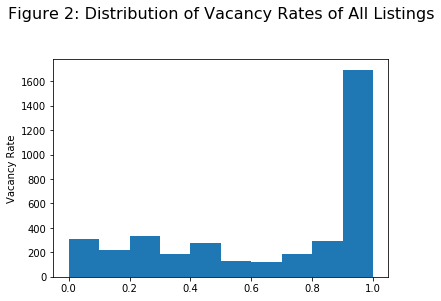

In [33]:
# This plot is to help me understand the data. It may confuse non-technical audience so won't be included on the blog
plt.hist(df_joined['vacancy_rate'])
plt.title('Distribution of Vacancy Rates of All Listings\n\n', fontsize = 16)
plt.ylabel('Number of Listings')
plt.ylabel('Vacancy Rate')

## 3.2 Add heatmap for vacancy by property type


Text(0.5,1,'Figure 1: Heatmap of Vacancy Rate by Property-type and Room-type\n\n')

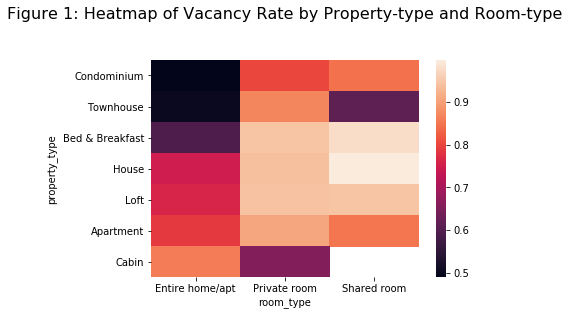

In [27]:
import seaborn as sns

df_vacancy_type_pivot = pd.pivot_table(df_vacancy_type,
                    index='property_type',
                    values='median',
                    columns='room_type')
df_vacancy_type_pivot.sort_values('Entire home/apt', inplace = True)

ax = plt.axes()
sns.heatmap(df_vacancy_type_pivot, ax = ax)
ax.set_title("Figure 1: Heatmap of Vacancy Rate by Property-type and Room-type\n\n", fontsize = 16)

## 3.3 Add plot for vacancy rate by cancellation policy

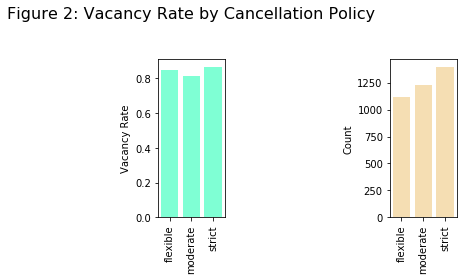

In [28]:

plt.subplot(1, 2, 1)
plt.bar(df_vacancy_cancel['cancellation_policy'], df_vacancy_cancel['median'], color = 'aquamarine')
plt.xticks(rotation=90)
plt.title('Figure 2: Vacancy Rate by Cancellation Policy\n\n', fontsize = 16)
plt.ylabel('Vacancy Rate')

plt.subplot(1, 2, 2)
plt.bar(df_vacancy_cancel['cancellation_policy'], df_vacancy_cancel['count'], color = 'wheat')
plt.xticks(rotation=90)
#plt.xlabel('time (s)')
plt.ylabel('Count')

plt.tight_layout()

plt.show()

## 3.4 Add plot for vacancy rate by minimum nights


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


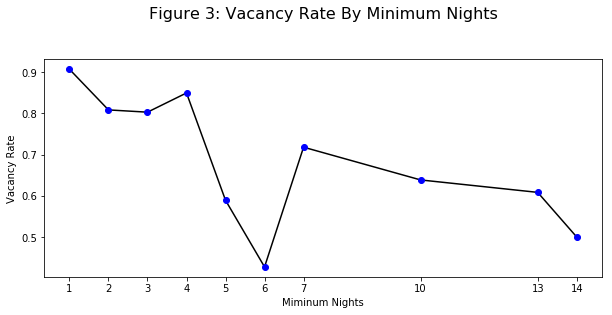

In [34]:
df_vacancy_minimum.sort_values("minimum_nights", inplace = True)
df_vacancy_minimum = df_vacancy_minimum[df_vacancy_minimum['count'] > 1]
plt.plot(df_vacancy_minimum['minimum_nights'], df_vacancy_minimum['median'], 'k',
        df_vacancy_minimum['minimum_nights'], df_vacancy_minimum['median'], 'bo')
plt.xticks(df_vacancy_minimum['minimum_nights'])
plt.xlabel("Miminum Nights")
plt.ylabel("Vacancy Rate")
plt.title("Figure 3: Vacancy Rate By Minimum Nights\n\n", fontsize = 16)
plt.gcf().set_size_inches(10, 4) 

In [30]:
df_vacancy_minimum

,minimum_nights,median,mean,count
0,1,0.906849,0.689856,1570
1,2,0.808219,0.659509,1397
2,3,0.802740,0.655736,477
3,4,0.849315,0.673927,121
4,5,0.589041,0.614108,67
5,6,0.427397,0.465925,16
6,7,0.717808,0.615945,50
7,8,0.526027,0.526027,1
8,10,0.638356,0.555616,5
9,11,0.142466,0.142466,1
